# San Francisco Crimes

## importing the libraries

In [583]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

## Loading the dataset to a dataframe

In [585]:
df = pd.read_csv('train.csv')

## Exploring the dataframe

In [587]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [588]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


## Turning the dates to hours, days, months and years

In [590]:
df['Dates'] = pd.to_datetime(df['Dates'])

In [591]:
df['Hour'] = df['Dates'].dt.hour
df['Day'] = df['Dates'].dt.day
df['Month'] = df['Dates'].dt.month
df['Year'] = df['Dates'].dt.year

In [592]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Hour,Day,Month,Year
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,13,5,2015
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,13,5,2015
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,23,13,5,2015
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,23,13,5,2015
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,23,13,5,2015


## Top 10 Crime Categories

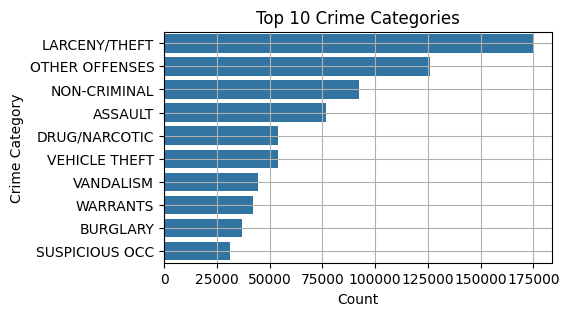

In [594]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df, y='Category', order=df['Category'].value_counts().head(10).index)
plt.title('Top 10 Crime Categories')
plt.xlabel('Count')
plt.ylabel('Crime Category')
plt.grid(True)
plt.show()

## Crimes by Hour of Day

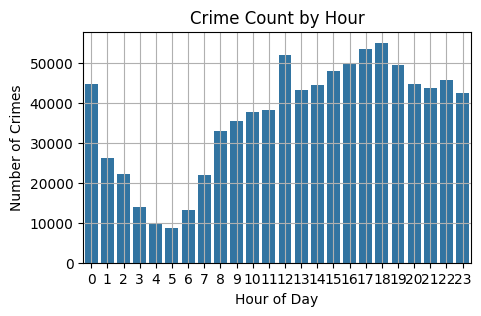

In [596]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Hour')
plt.title('Crime Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.show()

## Crimes by Day of Week

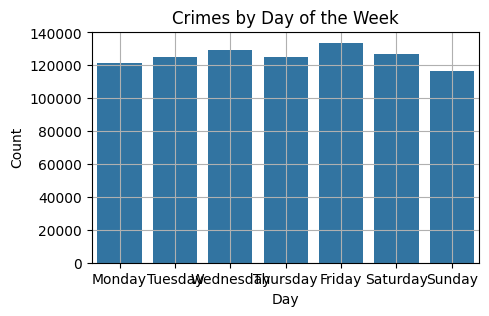

In [598]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='DayOfWeek', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Crimes by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## Crime Heatmap by Month and Hour

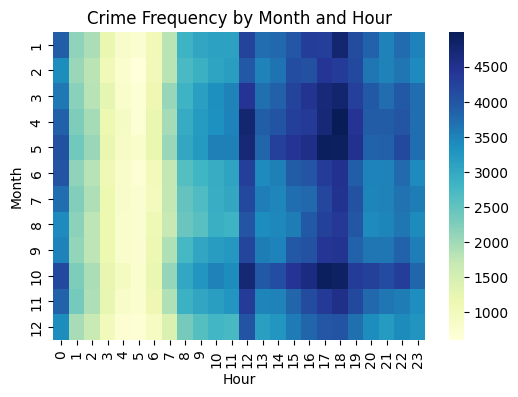

In [600]:
heatmap_data = df.groupby(['Month', 'Hour']).size().unstack()
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('Crime Frequency by Month and Hour')
plt.xlabel('Hour')
plt.ylabel('Month')
plt.show()

## Label encoding and non numeric features

In [602]:
label_encoder = LabelEncoder()

In [603]:
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

In [604]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Hour,Day,Month,Year
0,2015-05-13 23:53:00,37,866,6,4,0,19790,-122.425892,37.774599,23,13,5,2015
1,2015-05-13 23:53:00,21,810,6,4,0,19790,-122.425892,37.774599,23,13,5,2015
2,2015-05-13 23:33:00,21,810,6,4,0,22697,-122.424363,37.800414,23,13,5,2015
3,2015-05-13 23:30:00,16,404,6,4,11,4266,-122.426995,37.800873,23,13,5,2015
4,2015-05-13 23:30:00,16,404,6,5,11,1843,-122.438738,37.771541,23,13,5,2015


## Selecting the features to work with

In [606]:
correlations = df.corr()['Category'].sort_values(ascending=False)

In [607]:
print(correlations)

Category      1.000000
Descript      0.433396
Address       0.036355
Resolution    0.034913
Hour          0.023524
Day           0.000805
DayOfWeek     0.000388
Month         0.000008
Y            -0.000414
Year         -0.021803
Dates        -0.021808
X            -0.024401
PdDistrict   -0.040674
Name: Category, dtype: float64


/var/folders/7j/fk7__3j54fv0wqh73h0dtv700000gn/T/ipykernel_1713/957457077.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


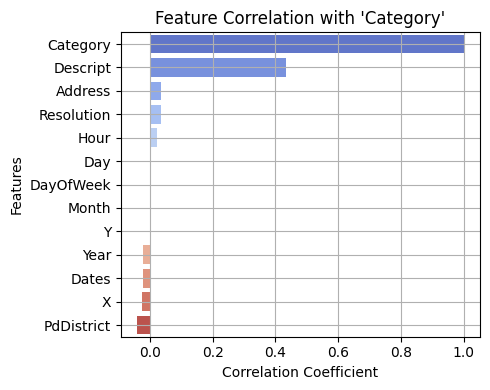

In [667]:
plt.figure(figsize=(5, 4))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title("Feature Correlation with 'Category'")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

In [608]:
features = ['X', 'Y', 'Category', 'Hour', 'Day', 'Month', 'Year']

In [609]:
df_features = df[features]

## Removing Outliers

In [611]:
for col in df_features:
    Q1 = df_features[col].quantile(0.25)
    Q3 = df_features[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_features[(df_features[col] < lower_bound) | (df_features[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")

X: 60272 outliers
Y: 67 outliers
Category: 78795 outliers
Hour: 0 outliers
Day: 0 outliers
Month: 0 outliers
Year: 0 outliers


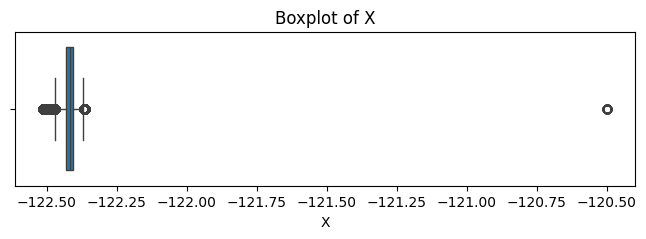

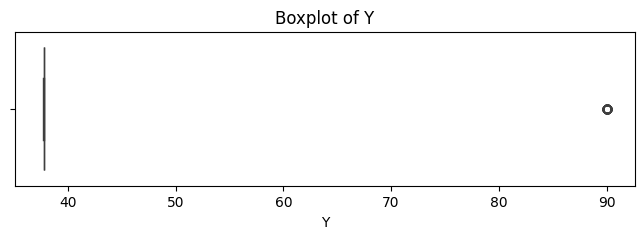

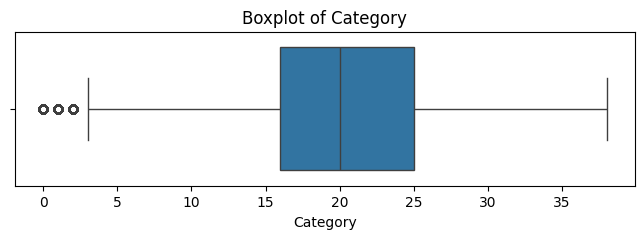

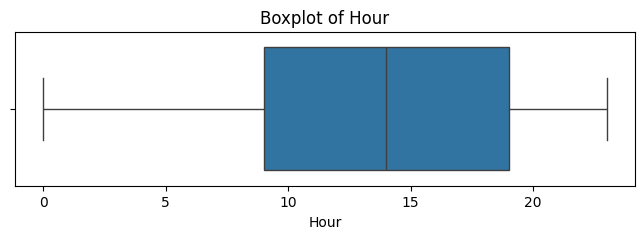

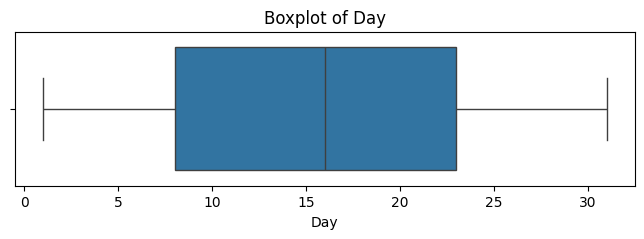

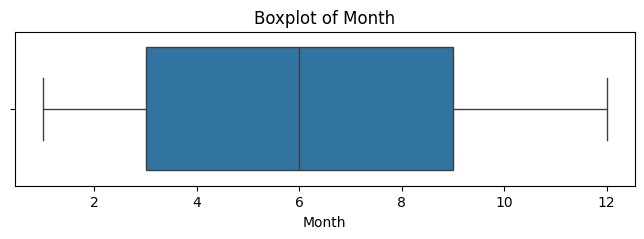

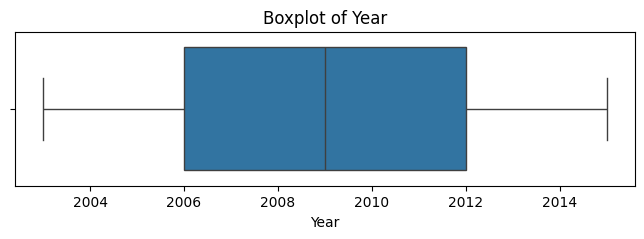

In [612]:
for col in df_features.columns:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df_features[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

In [613]:
cols_with_outliers = ['X', 'Y', 'Category']

In [614]:
for col in cols_with_outliers:
    Q1 = df_features[col].quantile(0.25)
    Q3 = df_features[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_features = df_features[(df_features[col] >= lower_bound) & (df_features[col] <= upper_bound)]

In [615]:
df_features.head()

,X,Y,Category,Hour,Day,Month,Year
0,-122.425892,37.774599,37,23,13,5,2015
1,-122.425892,37.774599,21,23,13,5,2015
2,-122.424363,37.800414,21,23,13,5,2015
3,-122.426995,37.800873,16,23,13,5,2015
4,-122.438738,37.771541,16,23,13,5,2015


In [616]:
df_features = df_features.sample(n=10000, random_state=42)

In [617]:
scaler = StandardScaler()

## Standard scaling all features

In [619]:
df_features_scaled = pd.DataFrame(
    scaler.fit_transform(df_features),
    columns=df_features.columns,
    index=df_features.index
)

In [620]:
df_features_scaled.head()

,X,Y,Category,Hour,Day,Month,Year
772606,0.151978,-0.053559,-0.007778,-0.394890,1.406461,-0.424574,-1.292872
525225,-0.515912,0.173472,1.477736,-0.704086,-0.299071,1.603414,-0.459531
603335,-0.376103,1.027938,-0.644427,1.305688,0.496844,1.023989,-0.737311
516636,-1.509575,0.586851,-0.538318,0.223502,-1.322390,-1.293712,-0.181751
200340,1.210407,-1.915264,0.416655,-0.240292,0.269440,0.734277,0.929369


## Applying pca to reduce the dimentionality

In [622]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(df_features_scaled)

## Applying k-medoid clustering

In [624]:
kmedoids = KMedoids(n_clusters=5, random_state=42)
clusters = kmedoids.fit_predict(reduced_features)

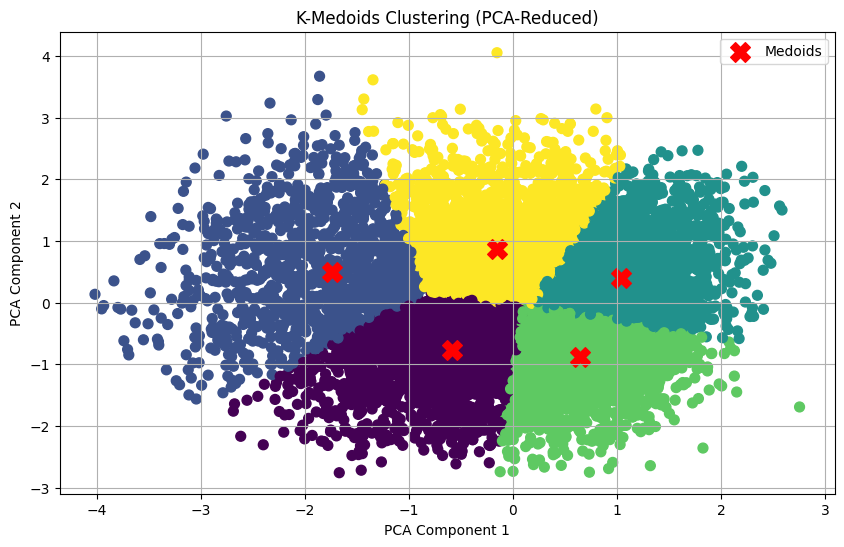

In [625]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50)
medoid_points = pca.transform(df_features_scaled.iloc[kmedoids.medoid_indices_])
plt.scatter(medoid_points[:, 0], medoid_points[:, 1], color='red', marker='X', s=200, label='Medoids')

plt.title("K-Medoids Clustering (PCA-Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


## Applying Hieurarical clustering

In [627]:
Z = linkage(reduced_features, method='ward')

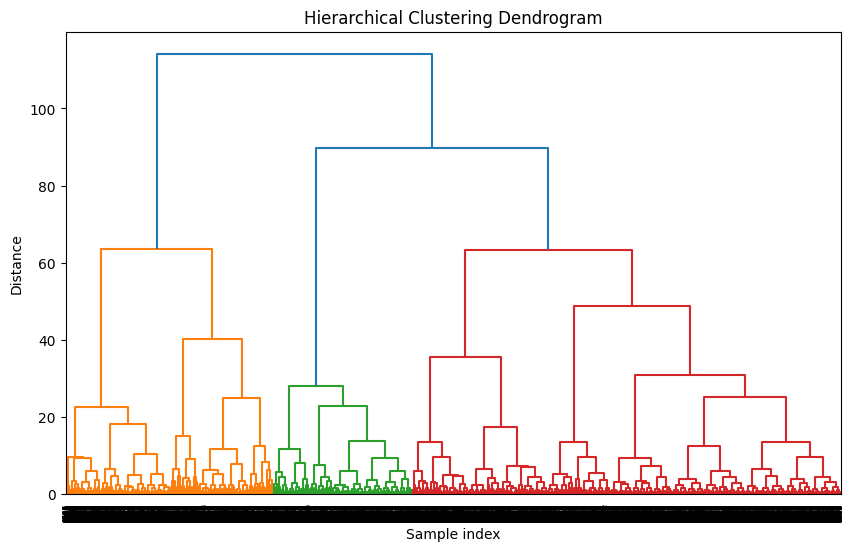

In [628]:
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()